In [1]:
import pickle
import glob
import pathlib
import random
import os
import copy

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.utils import plot_model
from keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score

import logging
from datetime import datetime

tf.__version__

2022-08-24 16:04:52.955936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 16:04:52.955953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.9.1'

In [2]:
tf.random.set_seed(10)

# 1. Get Folds

In [3]:
def get_training_folds(n_folds):
    
    # Get all subjects
    subjs = [pathlib.Path(f).stem for f in glob.glob(DATASET_PATH+'*.tfrecord')]
    
    # Partition into groups
    subj_groups = np.array_split(
        subjs,
        n_folds
    )
    
    # Divide train-test in leave-one-group-out
    train_test_splits = {}
    for i in range(0, n_folds):
        train_test_splits.update(
            {
                str(i): {
                    'train': np.hstack(np.delete(subj_groups, i)),
                    'test': subj_groups[i]
                }
            }
        )
        
    return train_test_splits
    
    

In [4]:
# Paths for reading data
DATASET_PATH = './proc_dataset/'

# Number of folds and train percentage
N_FOLDS=5

# Create folder for saving artifacts, if not yet created
MODELS_DIR = './artifacts/model_training/'
if not os.path.isdir(MODELS_DIR):
    os.mkdir(MODELS_DIR)
    
# Create folds or read folds
CREATE_FOLDS = True
if CREATE_FOLDS:
    train_test_folds = get_training_folds(
        n_folds=N_FOLDS
    )
    with open(MODELS_DIR+'train_test_folds.pkl', 'wb') as f:
        pickle.dump(train_test_folds, f)
else:
    with open(MODELS_DIR+'train_test_folds.pkl', 'rb') as f:
        train_test_folds = pickle.load(f)
        
print('-'*100)
print('Number of folds: {}'.format(
        len([v for v in train_test_folds.values()])
    ) 
)
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of folds: 5
----------------------------------------------------------------------------------------------------


/home/leonardo/py3env/lib/python3.8/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


# 2. Functions and Params for Parsing TFRecords

In [5]:
def read_parse_dataset(
    subjs,
    schema,
    return_type
):
    
    def __decode_example(
        protos,
        schema,
        return_type
    ):
        # Parse protos
        parsed = tf.io.parse_single_example(protos, schema)
        
        # Get components from protos
        eeg_raw = parsed['eeg_raw']
        eeg_feats = parsed['eeg_feats']
        label = parsed['label']
        
        # Return according to given return type
        if return_type=='raw':
            return eeg_raw, label
        elif return_type=='feats':
            return eeg_feats, label
        elif return_type=='full':
            return (eeg_raw, eeg_feats), label            
        
    def __parse_tfrecords(
        filenames,
        schema,
        return_type
    ):
        # Get dataset
        return tf.data.TFRecordDataset(
            filenames
        ).map(
            lambda x: __decode_example(
                protos=x,
                schema=schema,
                return_type=return_type
            )
        ).shuffle(
            BATCH_SIZE
        ).batch(
            BATCH_SIZE
        )
    
    def __get_subjs_files(subjs):
        
        # Read all subject files
        proc_files = glob.glob(DATASET_PATH+'*.tfrecord')

        # Get files that correspond to one of the selected subjects
        subjs_files = [f for f in proc_files if pathlib.Path(f).stem in subjs]
        
        return subjs_files
    
    # Get filenames for tf records in path
    filenames = __get_subjs_files(subjs=subjs)
    
    # Get dataset
    dataset = __parse_tfrecords(
        filenames=filenames,
        schema=schema,
        return_type=return_type
    )
    
    return dataset

In [6]:
BATCH_SIZE=128

# Schema for saved TFRecord files
FEATURES_SCHEMA = {
    'eeg_raw': tf.io.FixedLenFeature((3000,), tf.float32),
    'eeg_feats': tf.io.FixedLenFeature((72,), tf.float32),
    'label': tf.io.FixedLenFeature([5], tf.float32)
}

# 3. Model functions

In [7]:
#####################
# PARAMS FOR MODELS #
#####################

EEG_RAW_SIZE=3000
CNN_FILTERS=64
DROPOUT_RATE=0.01
DENSE_SIZE = 150
MAX_EPOCHS = 1000

## 3.1. Raw signal

In [8]:
def get_raw_model(lr):
    
    ###############
    # CONV BRANCH #
    ###############
    
    raw_inputs = keras.Input(
        shape=(3000,1),
        name="eeg_raw_input"
    )
    
    # FIRST LAYER OF PARALLEL CONVS+LSTM
    # First Conv 3
    conv1 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(raw_inputs)
    batchnorm_conv1 = keras.layers.BatchNormalization()(conv1)
    dropout1 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv1)
    maxpool1 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout1)
    
    # Second Conv 3
    conv2 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(maxpool1)
    batchnorm_conv2 = keras.layers.BatchNormalization()(conv2)
    dropout2 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv2)
    maxpool2 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout2)
    
    # Third Conv 3
    conv3 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(maxpool2)
    batchnorm_conv3 = keras.layers.BatchNormalization()(conv3)
    dropout3= keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv3)
    maxpool3 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout3)
    
    # Third Conv 3
    conv4 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(maxpool3)
    batchnorm_conv4 = keras.layers.BatchNormalization()(conv4)
    dropout4= keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv4)
    maxpool4 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout4)
    
    # Third Conv 3
    conv5 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(maxpool4)
    batchnorm_conv5 = keras.layers.BatchNormalization()(conv5)
    dropout5 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv5)
    maxpool5 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout5)
    
    
    # Flatten
    flat = keras.layers.Flatten()(maxpool5)
    
    ################
    # MERGE BRANCH #
    ################
    
    # Dense block
    dense1=keras.layers.Dense(DENSE_SIZE, activation='tanh')(flat)
    batchnorm_dense1 = keras.layers.BatchNormalization()(dense1)
    dropout_dense1 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense1)
    dense2=keras.layers.Dense(DENSE_SIZE, activation='tanh')(dropout_dense1)
    batchnorm_dense2 = keras.layers.BatchNormalization()(dense2)
    dropout_dense2 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense2)
    dense3=keras.layers.Dense(DENSE_SIZE, activation='tanh')(dropout_dense2)
    batchnorm_dense3 = keras.layers.BatchNormalization()(dense3)
    dropout_dense3 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense3)
    
    # Reshape output - pre-sequence branch
    outputs = keras.layers.Dense(5, activation='softmax', name='eeg_feats_outputs')(dropout_dense3)
    
    model = keras.Model(
        inputs=raw_inputs,
        outputs=outputs
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=lr,
        ),
        loss=[
            keras.losses.CategoricalCrossentropy()
        ],
        metrics=[
            keras.metrics.CategoricalAccuracy(),
        ]
    )
    
    return model

2022-08-24 16:04:54.307886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-24 16:04:54.308612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-24 16:04:54.308658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-24 16:04:54.308698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-24 16:04:54.308737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_raw_input (InputLayer)  [(None, 3000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 3000, 64)          256       
                                                                 
 batch_normalization (BatchN  (None, 3000, 64)         256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3000, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1000, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1000, 64)          12352 

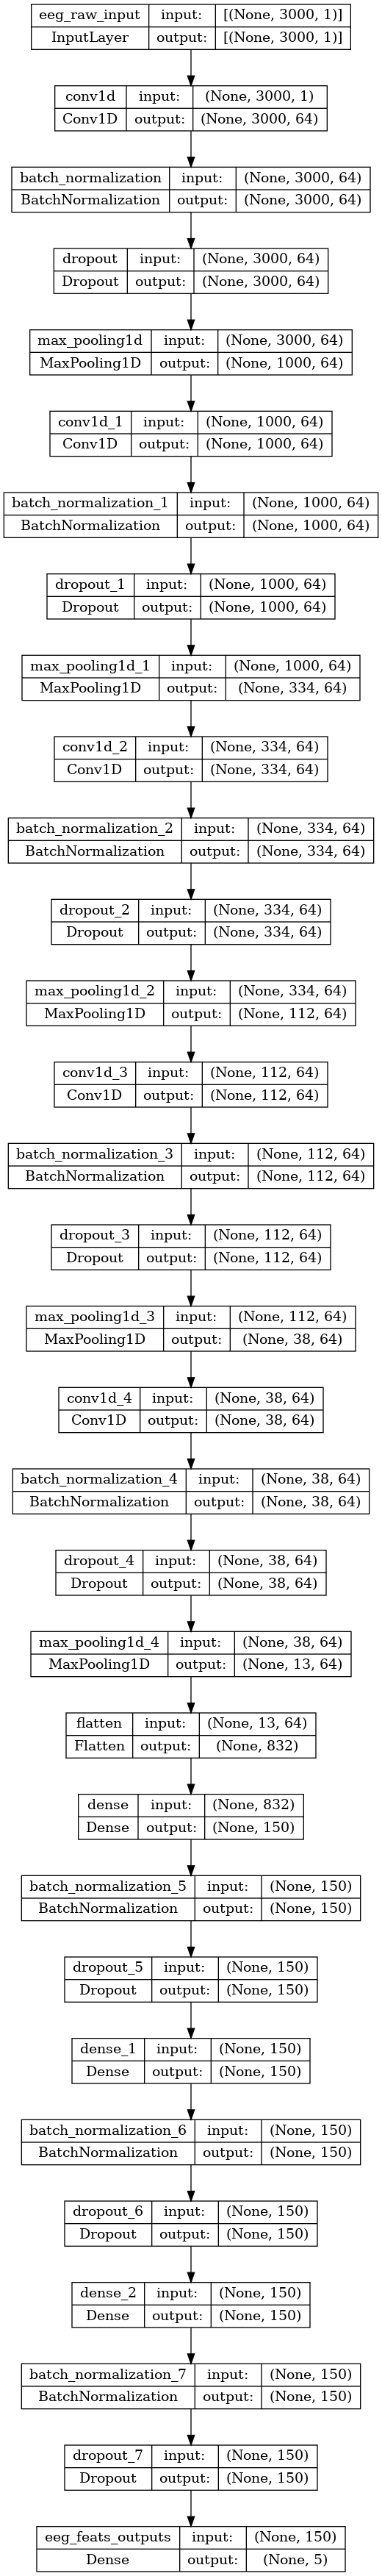

In [9]:
# Show model description and plot graph
sample_raw_model = get_raw_model(lr=0.0001)
print(sample_raw_model.summary())
plot_model(
        sample_raw_model,
        show_shapes=True,
        show_layer_names=True
    )

## 3.2. EEG Features

In [10]:
def get_feats_model(lr):
    
    ################
    # FEATS BRANCH #
    ################
    
    feats_inputs = keras.Input(
        shape=(72,),
        name="eeg_feats_inputs"
    )
    
    # Dense block
    feats_feats_dense1=keras.layers.Dense(DENSE_SIZE, activation='tanh')(feats_inputs)
    feats_batchnorm_dense1 = keras.layers.BatchNormalization()(feats_feats_dense1)
    feats_dropout_dense1 = keras.layers.Dropout(DROPOUT_RATE)(feats_batchnorm_dense1)
    feats_dense2=keras.layers.Dense(DENSE_SIZE, activation='tanh')(feats_dropout_dense1)
    feats_batchnorm_dense2 = keras.layers.BatchNormalization()(feats_dense2)
    feats_dropout_dense2 = keras.layers.Dropout(DROPOUT_RATE)(feats_batchnorm_dense2)
    feats_dense3=keras.layers.Dense(DENSE_SIZE, activation='tanh')(feats_dropout_dense2)
    feats_batchnorm_dense3 = keras.layers.BatchNormalization()(feats_dense3)
    feats_dropout_dense3 = keras.layers.Dropout(DROPOUT_RATE)(feats_batchnorm_dense3)
    
    
    ################
    # MERGE BRANCH #
    ################
    
    # Dense block
    dense1=keras.layers.Dense(DENSE_SIZE, activation='tanh')(feats_dropout_dense3)
    batchnorm_dense1 = keras.layers.BatchNormalization()(dense1)
    dropout_dense1 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense1)
    dense2=keras.layers.Dense(DENSE_SIZE, activation='tanh')(dropout_dense1)
    batchnorm_dense2 = keras.layers.BatchNormalization()(dense2)
    dropout_dense2 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense2)
    dense3=keras.layers.Dense(DENSE_SIZE, activation='tanh')(dropout_dense2)
    batchnorm_dense3 = keras.layers.BatchNormalization()(dense3)
    dropout_dense3 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense3)
    
    # Reshape output - pre-sequence branch
    outputs = keras.layers.Dense(5, activation='softmax', name='eeg_feats_outputs')(dropout_dense3)
    
    model = keras.Model(
        inputs=feats_inputs,
        outputs=outputs
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=lr,
        ),
        loss=[
            keras.losses.CategoricalCrossentropy()
        ],
        metrics=[
            keras.metrics.CategoricalAccuracy(),
        ]
    )
    
    return model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_feats_inputs (InputLaye  [(None, 72)]             0         
 r)                                                              
                                                                 
 dense_3 (Dense)             (None, 150)               10950     
                                                                 
 batch_normalization_8 (Batc  (None, 150)              600       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 150)               22650     
                                                                 
 batch_normalization_9 (Batc  (None, 150)              600 

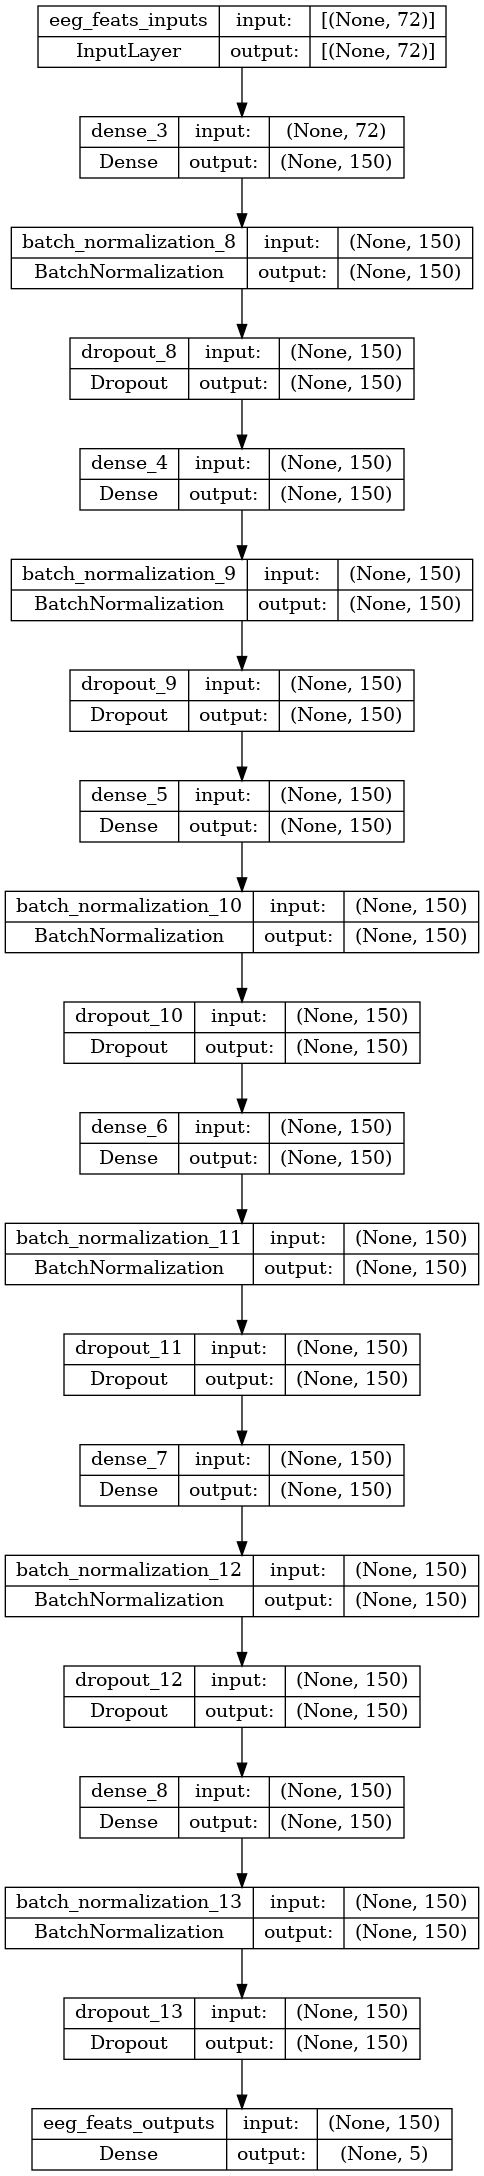

In [11]:
# Show model description and plot graph
sample_feats_model = get_feats_model(lr=0.001)
print(sample_feats_model.summary())
plot_model(
        sample_feats_model,
        show_shapes=True,
        show_layer_names=True
    )

## 3.3. Full - Raw signal + EEG Features

In [12]:
def get_full_model(lr):
    
    ###############
    # CONV BRANCH #
    ###############
    
    raw_inputs = keras.Input(
        shape=(3000,1),
        name="eeg_raw_input"
    )
    
    # FIRST LAYER OF PARALLEL CONVS+LSTM
    # First Conv 3
    conv1 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(raw_inputs)
    batchnorm_conv1 = keras.layers.BatchNormalization()(conv1)
    dropout1 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv1)
    maxpool1 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout1)
    
    # Second Conv 3
    conv2 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(maxpool1)
    batchnorm_conv2 = keras.layers.BatchNormalization()(conv2)
    dropout2 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv2)
    maxpool2 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout2)
    
    # Third Conv 3
    conv3 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(maxpool2)
    batchnorm_conv3 = keras.layers.BatchNormalization()(conv3)
    dropout3= keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv3)
    maxpool3 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout3)
    
    # Third Conv 3
    conv4 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(maxpool3)
    batchnorm_conv4 = keras.layers.BatchNormalization()(conv4)
    dropout4= keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv4)
    maxpool4 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout4)
    
    # Third Conv 3
    conv5 = keras.layers.Conv1D(
        filters=CNN_FILTERS,
        kernel_size=(3,),
        padding='same',
        activation='tanh',
    )(maxpool4)
    batchnorm_conv5 = keras.layers.BatchNormalization()(conv5)
    dropout5 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_conv5)
    maxpool5 = keras.layers.MaxPooling1D(pool_size=3, padding='same')(dropout5)
    
    
    # Flatten
    flat = keras.layers.Flatten()(maxpool5)
    
    ################
    # FEATS BRANCH #
    ################
    
    feats_inputs = keras.Input(
        shape=(72,),
        name="eeg_feats_inputs"
    )
    
    # Dense block
    feats_feats_dense1=keras.layers.Dense(DENSE_SIZE, activation='tanh')(feats_inputs)
    feats_batchnorm_dense1 = keras.layers.BatchNormalization()(feats_feats_dense1)
    feats_dropout_dense1 = keras.layers.Dropout(DROPOUT_RATE)(feats_batchnorm_dense1)
    feats_dense2=keras.layers.Dense(DENSE_SIZE, activation='tanh')(feats_dropout_dense1)
    feats_batchnorm_dense2 = keras.layers.BatchNormalization()(feats_dense2)
    feats_dropout_dense2 = keras.layers.Dropout(DROPOUT_RATE)(feats_batchnorm_dense2)
    feats_dense3=keras.layers.Dense(DENSE_SIZE, activation='tanh')(feats_dropout_dense2)
    feats_batchnorm_dense3 = keras.layers.BatchNormalization()(feats_dense3)
    feats_dropout_dense3 = keras.layers.Dropout(DROPOUT_RATE)(feats_batchnorm_dense3)
    
    
    ################
    # MERGE BRANCH #
    ################
    merged = keras.layers.concatenate(
        [
            feats_dropout_dense3,
            flat
        ]
    )
    
    # Dense block
    dense1=keras.layers.Dense(DENSE_SIZE, activation='tanh')(merged)
    batchnorm_dense1 = keras.layers.BatchNormalization()(dense1)
    dropout_dense1 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense1)
    dense2=keras.layers.Dense(DENSE_SIZE, activation='tanh')(dropout_dense1)
    batchnorm_dense2 = keras.layers.BatchNormalization()(dense2)
    dropout_dense2 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense2)
    dense3=keras.layers.Dense(DENSE_SIZE, activation='tanh')(dropout_dense2)
    batchnorm_dense3 = keras.layers.BatchNormalization()(dense3)
    dropout_dense3 = keras.layers.Dropout(DROPOUT_RATE)(batchnorm_dense3)
    
    # Reshape output - pre-sequence branch
    outputs = keras.layers.Dense(5, activation='softmax', name='eeg_feats_outputs')(dropout_dense3)
    
    model = keras.Model(
        inputs=[
            raw_inputs,
            feats_inputs
        ],
        outputs=outputs
    )
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=lr,
        ),
        loss=[
            keras.losses.CategoricalCrossentropy()
        ],
        metrics=[
            keras.metrics.CategoricalAccuracy(),
        ]
    )
    
    return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 eeg_raw_input (InputLayer)     [(None, 3000, 1)]    0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 3000, 64)     256         ['eeg_raw_input[0][0]']          
                                                                                                  
 batch_normalization_14 (BatchN  (None, 3000, 64)    256         ['conv1d_5[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dropout_14 (Dropout)           (None, 3000, 64)     0           ['batch_normalization_14[0]

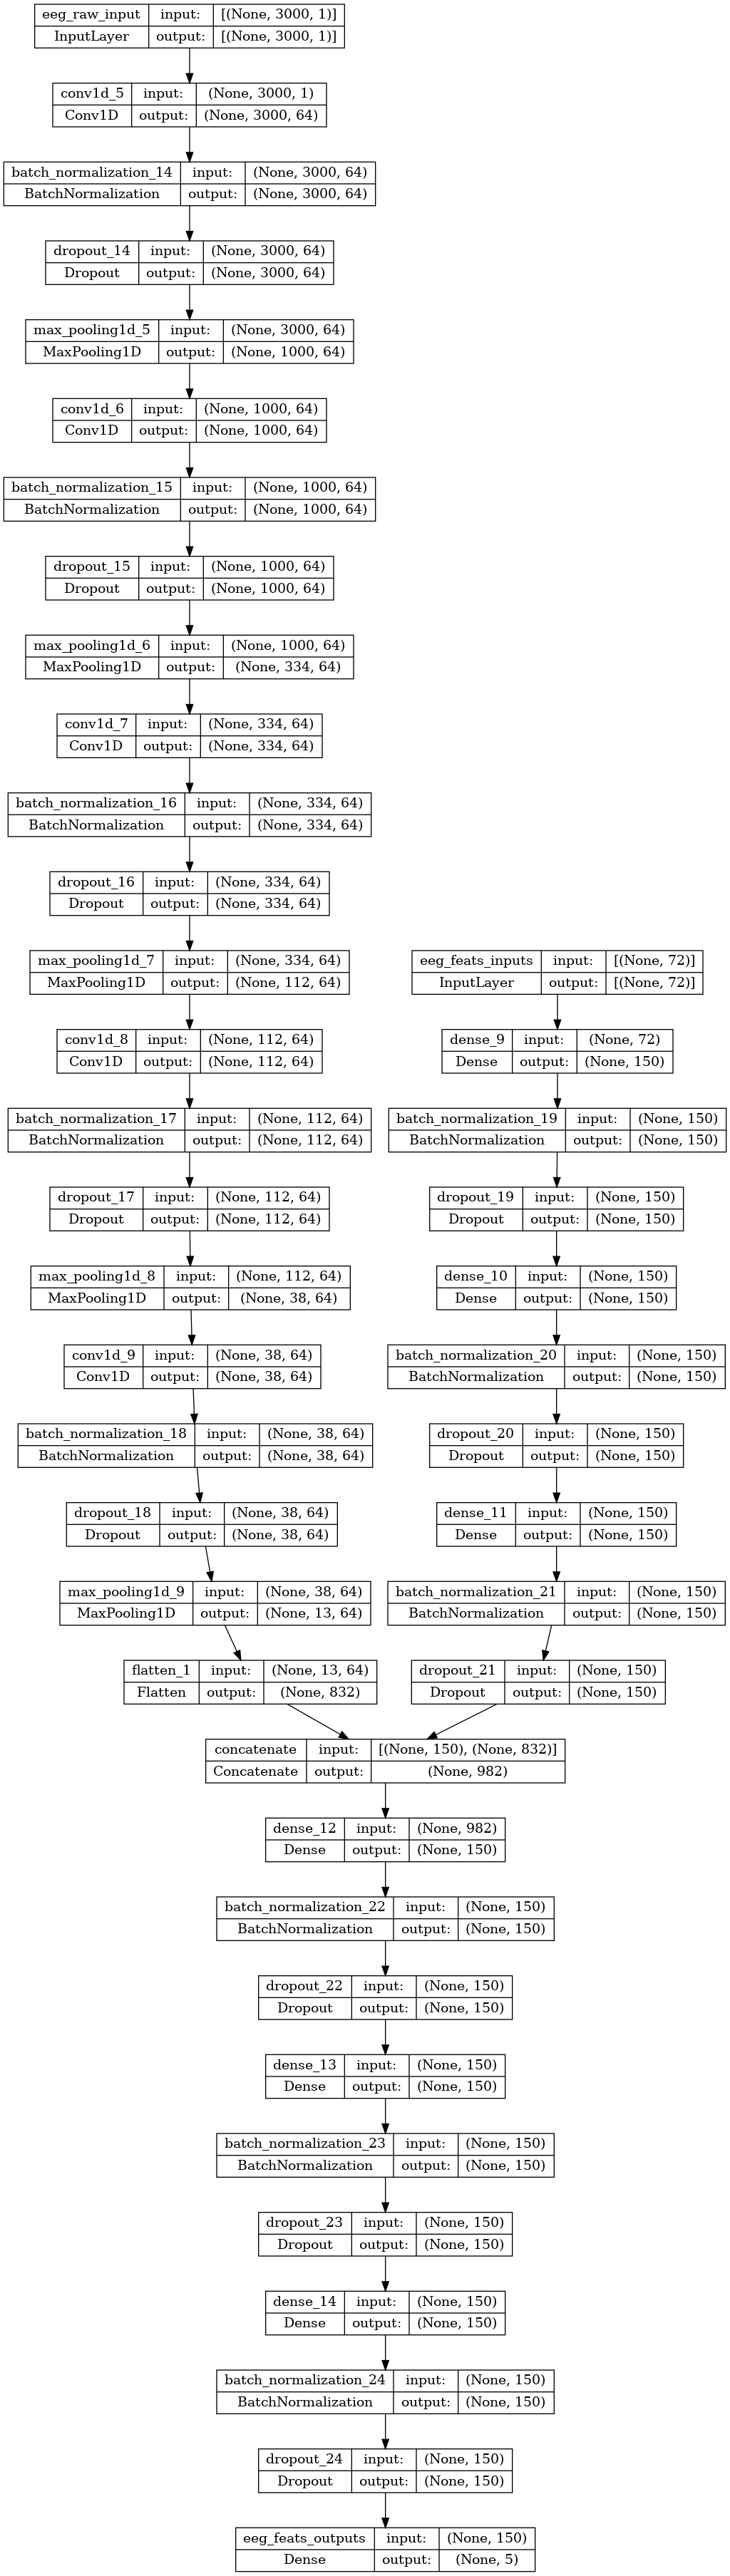

In [13]:
# Show model description and plot graph
sample_full_model = get_full_model(lr=0.001)
print(sample_full_model.summary())
plot_model(
        sample_full_model,
        show_shapes=True,
        show_layer_names=True
    )

# 4. Perform CV Train and Eval

In [14]:
def format_history(
    history,
    fold,
    model_type
):
    # Get df from history object
    history_df = pd.DataFrame(
        history.history
    ).reset_index().rename(
        columns={'index':'epoch'}
    )
    
    # Add epoch, model_type and fold cols
    history_df['epoch'] += 1
    history_df['fold'] = fold
    history_df['model_type'] = model_type
    
    return history_df


def get_model_performance(
    model,
    test_ds
):
    # Predict over each batch, record true and predicted labels
    y_true = []
    y_pred = []
    for elem in test_ds.as_numpy_iterator():
        # Get inputs for prediction
        X_pred_batch = elem[0]
        
        # Get predictions for inputs
        y_pred_batch = [
          LABEL_CONVERT[np.argmax(y_pred)] for y_pred in model.predict(X_pred_batch, verbose=0)
        ]
        
        # Get true values
        y_true_batch = [
            LABEL_CONVERT[np.argmax(y)] for y in elem[-1]
        ]
        
        # Record batch results
        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)
        
        
    # Get confusion matrix
    confusion = pd.DataFrame(
        index=CLASS_LABELS,
        columns=CLASS_LABELS,
        data=confusion_matrix(
            y_true=y_true,
            y_pred=y_pred,
            labels=CLASS_LABELS
        )
    )

    # Scale each row (true classes) by its sum
    confusion_scaled = confusion.divide(np.sum(confusion, axis=1), axis='rows')
    
    # Get precision
    precision = {
        l: confusion.divide(np.sum(confusion)).iloc[i,i] for i, l in enumerate(CLASS_LABELS)
    }
    precision_df = pd.DataFrame.from_dict(
        precision, 
        orient='index'
    ).reset_index().rename(
        columns={
            'index': 'class',
            0: 'precision'
        }
    )
    
    # Get recall
    recall = {
        l: confusion.divide(np.sum(confusion, axis=1), axis='rows').iloc[i,i] for i, l in enumerate(CLASS_LABELS)
    }

    recall_df = pd.DataFrame.from_dict(
        recall, 
        orient='index'
    ).reset_index().rename(
        columns={
            'index': 'class',
            0: 'recall'
        }
    )
    
    # Merge and get f1-score
    class_metrics = precision_df.merge(
        recall_df,
        on='class',
        how='inner'
    )
    class_metrics['f1'] = class_metrics.apply(lambda x: 2*(x[1]*x[2])/np.sum(x[1:]), axis=1)
    
    # Get global accuracy
    global_accuracy = accuracy_score(
        y_true=y_true,
        y_pred=y_pred
    )
    
    return {
        'accuracy': global_accuracy,
        'confusion_matrix': confusion,
        'confusion_matrix_scaled': confusion_scaled,
        'class_metrics': class_metrics
    }


def save_fold_artifacts(
    save_dir,
    fold,
    model,
    history,
    performance
):
    # Save model
    model.save(save_dir + 'model_fold{}.h5'.format(fold))
    
    # Save history
    history.to_csv(save_dir + 'history_fold{}.csv'.format(fold), index=False)
    
    # Save performance metrics
    with open(save_dir + 'performance_metrics_fold{}.pkl'.format(fold), 'wb') as f:
        pickle.dump(performance, f)


def train_evalCV_model(
    model_types,
    train_test_folds
):
    for model_type in model_types:
        logging.info('Beggining CV model training for model type {}'.format(model_type))
        MODEL_TYPE_DIR = MODELS_CV_DIR + model_type + '/'
        if not os.path.isdir(MODEL_TYPE_DIR):
            os.mkdir(MODEL_TYPE_DIR)
        for fold, specs in train_test_folds.items():
            logging.info('Beggining processing for model type {} and fold {}'.format(model_type, fold))
            # Get train/valid datasets
            logging.info('Obtaining train/valid datasets for model type {} and fold {}.'.format(model_type, fold))
            train_ds = read_parse_dataset(
                subjs = specs['train'],
                schema=FEATURES_SCHEMA,
                return_type=model_type
            )
            valid_ds = read_parse_dataset(
                subjs = specs['test'],
                schema=FEATURES_SCHEMA,
                return_type=model_type
            )

            # Get model
            model = MODEL_FNS[model_type](lr=0.001)

            # Declare early stopping callback
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=25,
                restore_best_weights=True
            )

            # Train model
            logging.info('Beginning model training for model type {} and fold {}.'.format(model_type, fold))
            train_start = datetime.now()
            history_part1 = model.fit(
                train_ds,
                epochs=10,
                batch_size=BATCH_SIZE,
                validation_data = valid_ds,
                verbose=0
            )
            K.set_value(model.optimizer.learning_rate, 0.0001)
            history_part2 = model.fit(
                train_ds,
                epochs=MAX_EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data = valid_ds,
                callbacks=[early_stopping],
                verbose=0
            )
            train_end = datetime.now()
            train_elapsed_time = (train_end - train_start).seconds
            logging.info('Finished model training for model type {} and fold {}. Elapsed time: {} minutes.'.format(model_type, fold, train_elapsed_time//60))

            # Format history object as table
            logging.info('Formatting training history for model type {} and fold {}.'.format(model_type, fold))
            history_df = pd.concat(
                [
                    format_history(
                        history=history_part1,
                        fold=fold,
                        model_type=model_type
                    ),
                    format_history(
                        history=history_part2,
                        fold=fold,
                        model_type=model_type
                    )
                ], axis=0
            ).drop(
                columns='epoch'
            ).reset_index(
                drop=True
            ).reset_index().rename(
                columns={'index': 'epoch'}
            )
            
            # Get model performance specs
            logging.info('Obtaining performance metrics for model type {} and fold {}.'.format(model_type, fold))
            performance_metrics = get_model_performance(
                model=model,
                test_ds=valid_ds
            )
            performance_metrics['training_time'] = train_elapsed_time
            
            # Save artifacts
            logging.info('Saving training/performance artifacts for model type {} and fold {}.'.format(model_type, fold))
            save_fold_artifacts(
                save_dir=MODEL_TYPE_DIR,
                fold=fold,
                model=model,
                history=history_df,
                performance=performance_metrics
            )
            
            logging.info('Finished run for model type {} and fold {}.'.format(model_type, fold))
            logging.info('-'*100)
        logging.info('#'*100)
        

In [15]:
MODEL_FNS = {
    'raw': get_raw_model,
    'feats': get_feats_model,
    'full': get_full_model
}
CLASS_LABELS = ['W', 'N1', 'N2', 'N3', 'R']
LABEL_CONVERT = {
    0: 'W',
    1: 'N1',
    2: 'N2',
    3: 'N3',
    4: 'R'
}
MODEL_TYPES = [
    'feats',
    'full',
    'raw'
]

# Create folder for saving artifacts, if not yet created
MODELS_CV_DIR = './artifacts/model_training/cv_results/'
if not os.path.isdir(MODELS_CV_DIR):
    os.mkdir(MODELS_CV_DIR)

# Configure logging
LOG_DIR = MODELS_CV_DIR + 'logs/'
if not os.path.isdir(LOG_DIR):
    os.mkdir(LOG_DIR)
logging.basicConfig(
    filename=LOG_DIR + 'cv_logs.log',
    filemode='a',
    format='%(asctime)s - %(message)s',
    level=logging.INFO
)
    
# Execute cv for model types
train_evalCV_model(
    model_types=MODEL_TYPES,
    train_test_folds=train_test_folds
)